# Deep Learning Small Project
Creating a model from scratch to classify covid-19 x-rays pictures

Members: Tiang Pei Yuan, Lim Yang Zhi, Heng Jing Han

# 0. Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from sklearn import metrics


# 1. Dataset object

## 1.1 Raw dataset for lung images

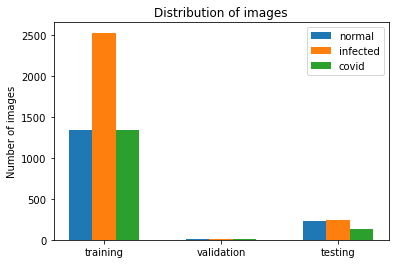

In [2]:
dataset_numbers = {'train_normal': 1341,\
                                'train_infected': 2530,\
                                'train_covid': 1345, \
                                'val_normal': 8,\
                                'val_infected': 8,\
                                'val_covid': 8, \
                                'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}


labels = ['training', 'validation', 'testing']
normal = [dataset_numbers['train_normal'], dataset_numbers['val_normal'], dataset_numbers['test_normal']]
infected = [dataset_numbers['train_infected'], dataset_numbers['val_infected'], dataset_numbers['test_infected']]
covid = [dataset_numbers['train_covid'], dataset_numbers['val_covid'], dataset_numbers['test_covid']]

x = np.arange(len(labels))  
width = 1  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/5, normal, width/5, label='normal')
rects2 = ax.bar(x , infected, width/5, label='infected')
rects3 = ax.bar(x + width/5, covid, width/5, label='covid')


ax.set_ylabel('Number of images')
ax.set_title('Distribution of images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

## 1.2 Data augmentation

In [3]:
from PIL import Image, ImageOps
import os
import numpy as np
import copy

## 1.2.1 Histogram Equalization

https://radiopaedia.org/articles/histogram-equalisation

Histogram equalization is used to enhance the contrast of images, and for x-ray data images where data is localized within a narrow band of values, histogram equalization can help us distribute the frequently occurring intensities

#### For the following code to work, please have full dataset in the same folder as this .ipynb file.

The following code creates new folders containing the images which have been augmented to have histogram equalization applied on them. The directory structure is the same as 'dataset' so that we can use these data easily 

In [4]:
try:
    os.makedirs('./dataset_hist_equalization/train/normal')
except FileExistsError:
    pass
try:
    os.makedirs('./dataset_hist_equalization/train/infected/non-covid')
except FileExistsError:
    pass
try:
    os.mkdir('./dataset_hist_equalization/train/infected/covid')
except FileExistsError:
    pass
try:
    os.makedirs('./dataset_hist_equalization/test/normal')
except FileExistsError:
    pass
try:
    os.makedirs('./dataset_hist_equalization/test/infected/non-covid')
except FileExistsError:
    pass
try:
    os.mkdir('./dataset_hist_equalization/test/infected/covid')
except FileExistsError:
    pass
try:
    os.makedirs('./dataset_hist_equalization/val/normal')
except FileExistsError:
    pass
try:
    os.makedirs('./dataset_hist_equalization/val/infected/non-covid')
except FileExistsError:
    pass
try:
    os.mkdir('./dataset_hist_equalization/val/infected/covid')
except FileExistsError:
    pass

def histogram_equalization(src_folder, dst_folder):
    '''
    datatype: 'train', 'test', or 'val' (string)
    src_folder: folder for the original images (string)
    dst_folder: folder to store images that have been applied histogram equalization (string)
    '''
    pre_string = './' + src_folder
    post_normal = '/normal'
    post_infected = '/infected/non-covid'
    post_covid = '/infected/covid'
    
    # PATH TO ORIGINAL IMAGES
    normal_path = pre_string + post_normal
    infected_path = pre_string + post_infected
    covid_path = pre_string + post_covid
    
    # PATH TO NEW AUGMENTED IMAGES
    dst_normal_path = './' + dst_folder + post_normal
    dst_infected_path = './' + dst_folder + post_infected
    dst_covid_path = './' + dst_folder + post_covid
    
    for file in os.listdir(normal_path):
        new_filename = dst_normal_path + '/' + file
        full_original_path = normal_path + '/' + file
        im = Image.open(full_original_path)
        im_mirror = ImageOps.equalize(im)
        im_mirror.save(new_filename)

        
    for file in os.listdir(infected_path):
        new_filename = dst_infected_path + '/' + file
        full_original_path = infected_path + '/' + file
        im = Image.open(full_original_path)
        im_mirror = ImageOps.equalize(im)
        im_mirror.save(new_filename)
        
        
    for file in os.listdir(covid_path):
        new_filename = dst_covid_path + '/' + file
        full_original_path = covid_path + '/' + file
        im = Image.open(full_original_path)
        im_mirror = ImageOps.equalize(im)
        im_mirror.save(new_filename)
        
    print('Done')

src_folder = './dataset/val'
dst_folder = './dataset_hist_equalization/val'
histogram_equalization(src_folder, dst_folder)

src_folder = './dataset/test'
dst_folder = './dataset_hist_equalization/test'
histogram_equalization(src_folder, dst_folder)

src_folder = './dataset/train'
dst_folder = './dataset_hist_equalization/train'
histogram_equalization(src_folder, dst_folder)

"\nsrc_folder = './dataset/val'\ndst_folder = './dataset_hist_equalization/val'\nhistogram_equalization(src_folder, dst_folder)\n\nsrc_folder = './dataset/test'\ndst_folder = './dataset_hist_equalization/test'\nhistogram_equalization(src_folder, dst_folder)\n\nsrc_folder = './dataset/train'\ndst_folder = './dataset_hist_equalization/train'\nhistogram_equalization(src_folder, dst_folder)\n"

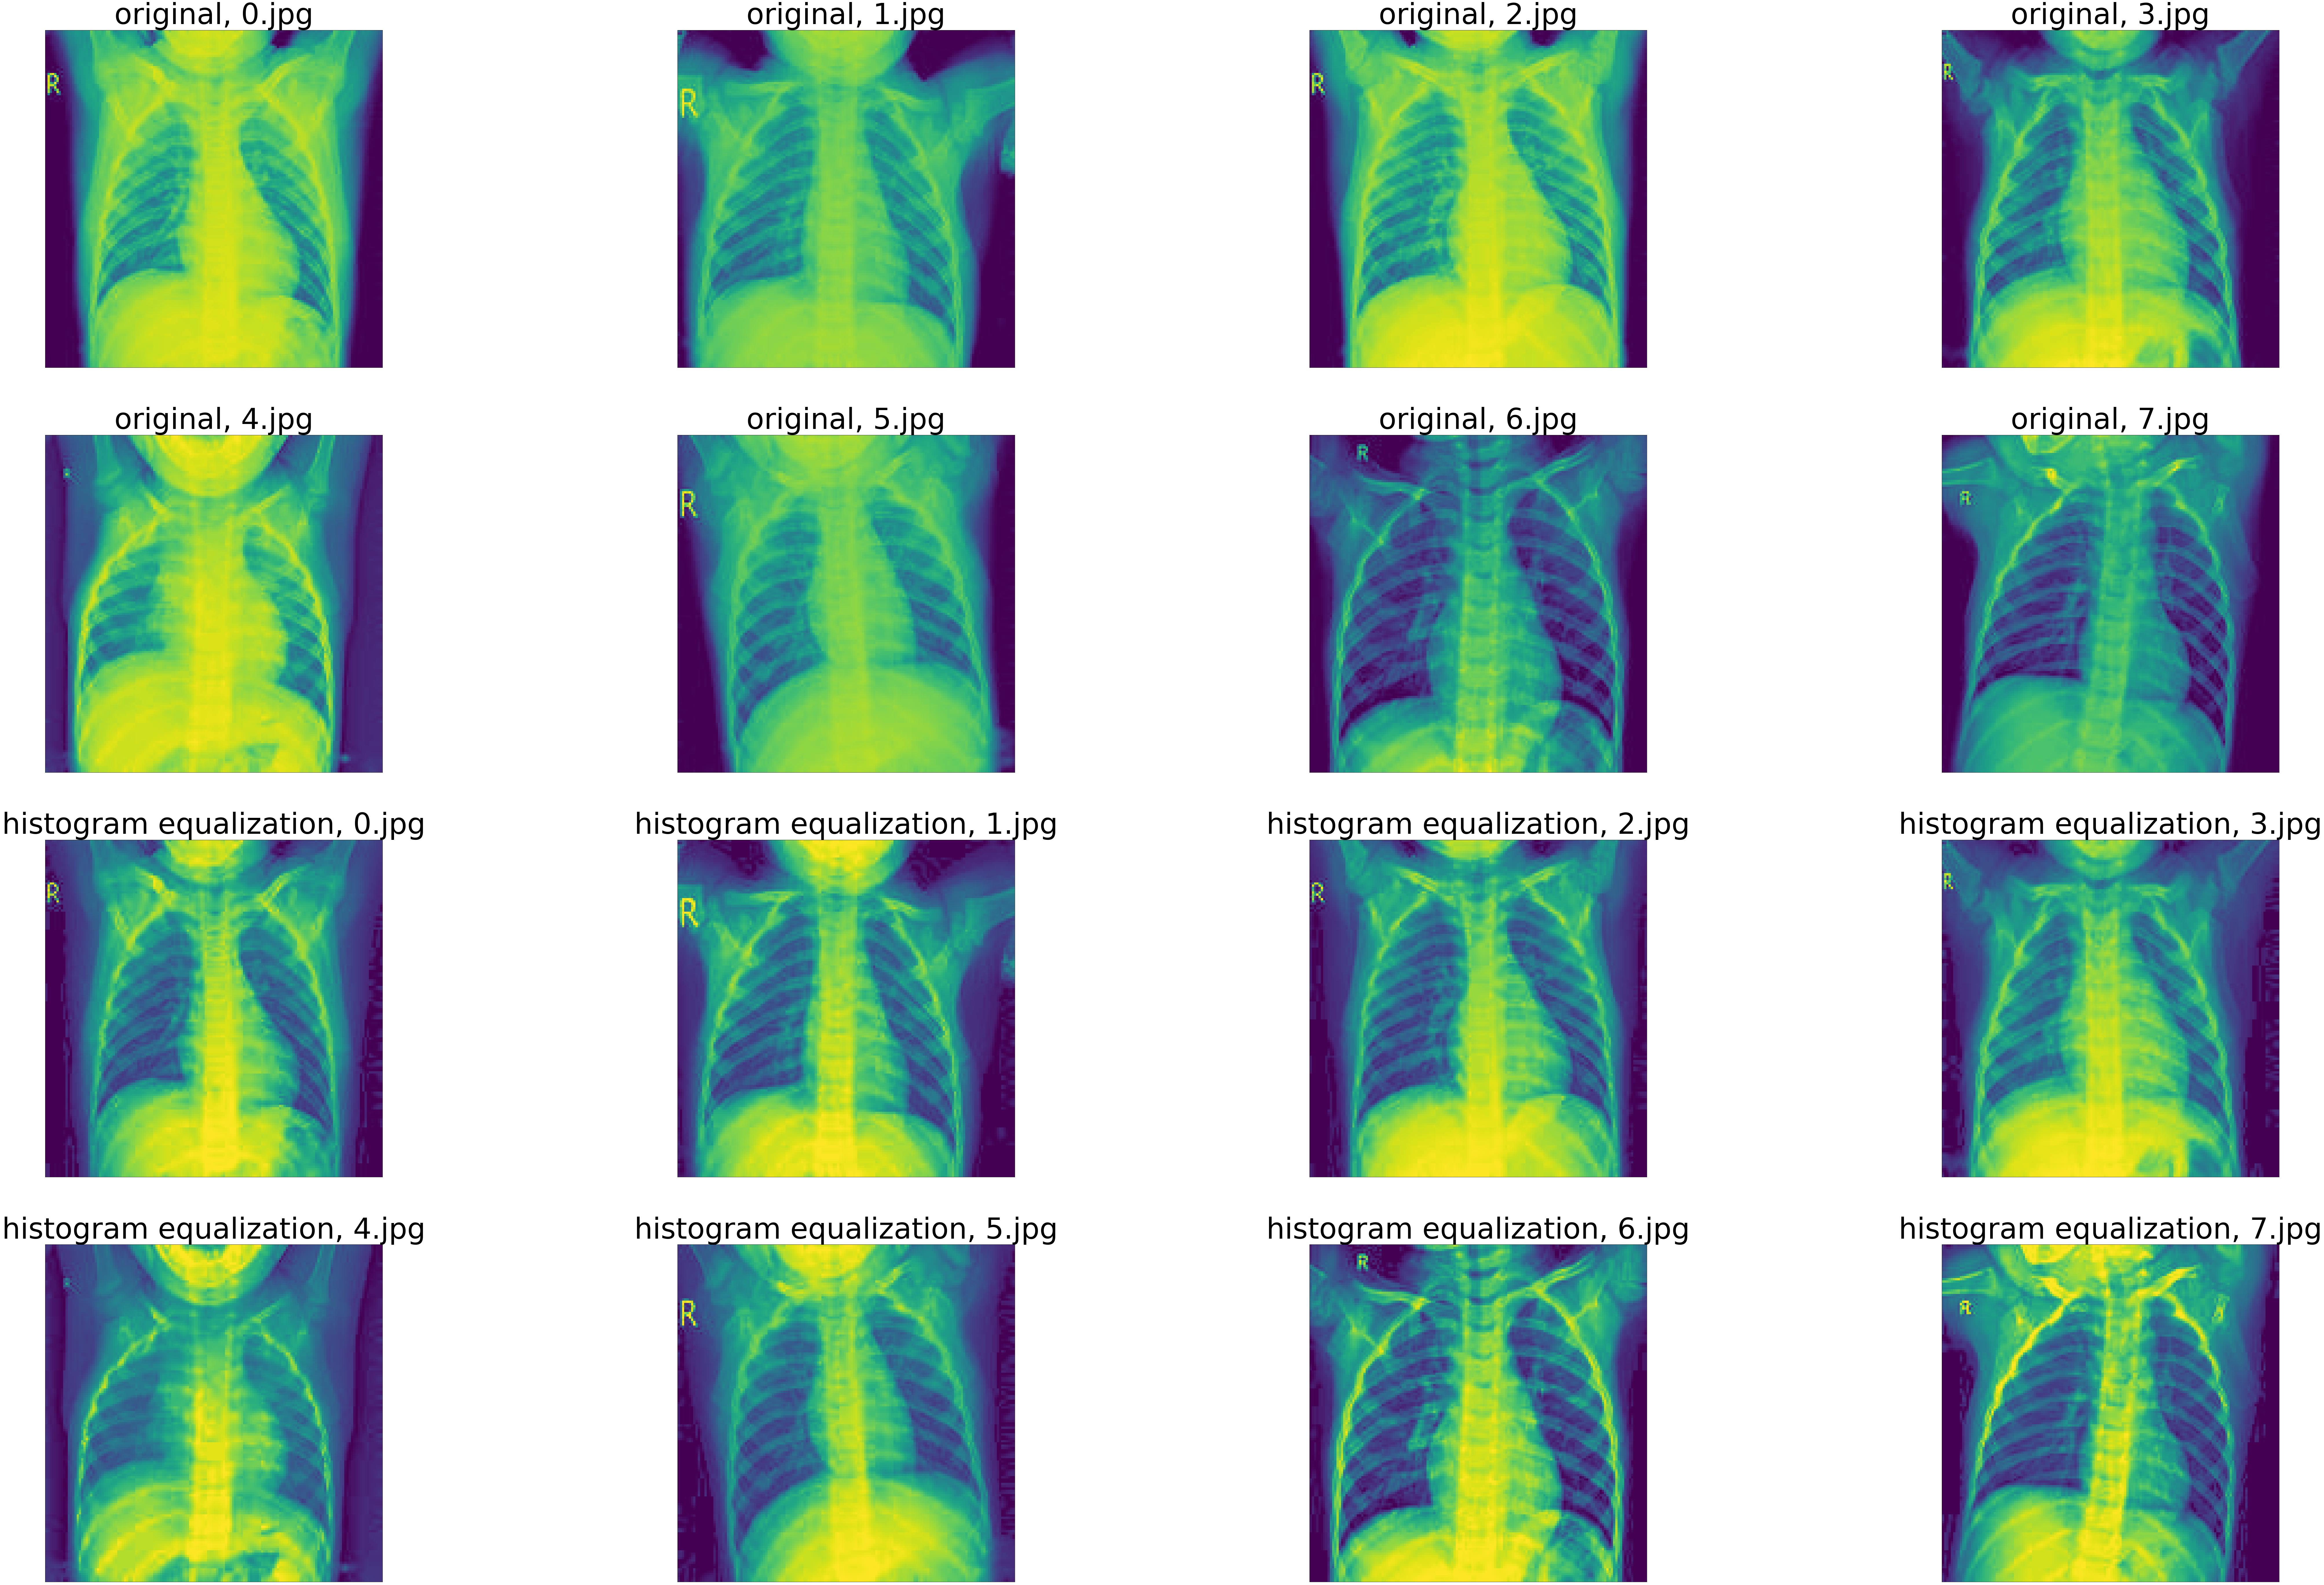

In [5]:
f = plt.figure(figsize=(150, 150))
axes = []

path_to_file = './dataset/val/normal/'
a=0

for file in os.listdir(path_to_file):
    
    axes.append(f.add_subplot(6, 4, a+1))
    
    plt.xticks([], [])
    plt.yticks([], [])
    
    subplot_title = 'original, ' + file
    axes[-1].set_title(subplot_title, size=100)
    
    full_image_path = path_to_file + file
    im = np.asarray(Image.open(full_image_path))
    plt.imshow(im)
    a += 1

path_to_file = './dataset_hist_equalization/val/normal/'

for file in os.listdir(path_to_file):
    
    axes.append(f.add_subplot(6, 4, a+1))
    
    plt.xticks([], [])
    plt.yticks([], [])
    
    subplot_title = 'histogram equalization, ' + file
    axes[-1].set_title(subplot_title, size=100)
    
    full_image_path = path_to_file + file
    im = np.asarray(Image.open(full_image_path))
    plt.imshow(im)
    a += 1
plt.show()

As seen from the plot above, the original data had different level of brightness and contrast. After histogram equalization is applied, the images appear to be more uniform in terms of brightness and contrast.

## 1.2.2 Mirroring augmented data

From the training dataset, we have 1341 normal images, 1345 covid images and 2530 non-covid images, which are quite unbalanced. In order to balance out the number of data for each class, we will be mirroring the normal and covid images to get more images. 

### WARNING: Do not run this code more than once, otherwise you will create duplicate images

In [6]:
def mirror_data(mirror_path):
    '''
    This function accepts a path and will produce a mirror for each image. Will result in twice the number of original files
    '''
    count_files = next(os.walk(mirror_path))[2] #count number of files in the directory
    number_of_files = len(count_files)
    
    if number_of_files > 2600:
        print('Already mirrored, quitting')
        return
    
    for file in os.listdir(mirror_path):
        full_image_path = mirror_path + '/' + file
        new_image_path = mirror_path + '/' + str(number_of_files) + '.jpg'
        
        im = Image.open(full_image_path)
        im_mirror = ImageOps.mirror(im)
        im_mirror.save(new_image_path)
        
        number_of_files += 1
    print('Done mirroring images for:', mirror_path)
    
mirror_data('./dataset_hist_equalization/train/normal')
mirror_data('./dataset_hist_equalization/train/infected/covid')

Already mirrored, quitting
Already mirrored, quitting


As seen below, the datasets are much more balanced after the mirroring of the images. This would be important in order to avoid biasedness in the model.

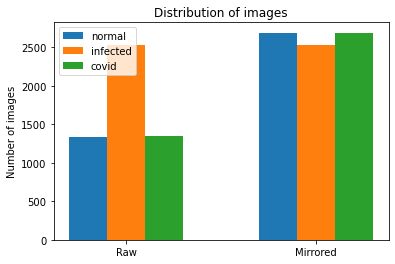

In [7]:
dataset_numbers = {'raw_train_normal': 1341,\
                   'raw_train_infected': 2530,\
                   'raw_train_covid': 1345,
                   'mirrored_train_normal': 2682,\
                   'mirrored_train_infected': 2530,\
                   'mirrored_train_covid': 2690}


labels = ['Raw', 'Mirrored']

normal = [dataset_numbers['raw_train_normal'], dataset_numbers['mirrored_train_normal']]
infected = [dataset_numbers['raw_train_infected'], dataset_numbers['mirrored_train_infected']]
covid = [dataset_numbers['raw_train_covid'], dataset_numbers['mirrored_train_covid']]

x = np.arange(len(labels))  
width = 1  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/5, normal, width/5, label='normal')
rects2 = ax.bar(x , infected, width/5, label='infected')
rects3 = ax.bar(x + width/5, covid, width/5, label='covid')


ax.set_ylabel('Number of images')
ax.set_title('Distribution of images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [8]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 2682,\
                                'train_infected': 2530,\
                                'train_covid': 2690, \
                                'val_normal': 8,\
                                'val_infected': 8,\
                                'val_covid': 8, \
                                'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset_hist_equalization/train/normal/',\
                              'train_infected': './dataset_hist_equalization/train/infected/non-covid/',\
                              'train_covid': './dataset_hist_equalization/train/infected/covid/', \
                              'val_normal': './dataset_hist_equalization/val/normal/',\
                              'val_infected': './dataset_hist_equalization/val/infected/non-covid/',\
                              'val_covid': './dataset_hist_equalization/val/infected/covid/', \
                              'test_normal': './dataset_hist_equalization/test/normal/',\
                              'test_infected': './dataset_hist_equalization/test/infected/non-covid/', \
                              'test_covid': './dataset_hist_equalization/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

## 1.3.1 Train dataset

In [9]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 2682,\
                                'train_infected': 2530,\
                                'train_covid': 2690}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset_hist_equalization/train/normal/',\
                              'train_infected': './dataset_hist_equalization/train/infected/non-covid', \
                              'train_covid': './dataset_hist_equalization/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'"
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [10]:
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 7902 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset_hist_equalization/train/normal/: 2682 images.
 - train_infected, in folder ./dataset_hist_equalization/train/infected/non-covid: 2530 images.
 - train_covid, in folder ./dataset_hist_equalization/train/infected/covid/: 2690 images.



In [11]:
print(len(ld_train))

7902


In [12]:
im, class_oh = ld_train[64]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1., 0., 0.])


## 1.3.2 Test dataset

In [13]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset_hist_equalization/test/normal/',\
                              'test_infected': './dataset_hist_equalization/test/infected/non-covid', \
                              'test_covid': './dataset_hist_equalization/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [14]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset_hist_equalization/test/normal/: 234 images.
 - test_infected, in folder ./dataset_hist_equalization/test/infected/non-covid: 242 images.
 - test_covid, in folder ./dataset_hist_equalization/test/infected/covid/: 138 images.



In [15]:
print(len(ld_test))

614


In [16]:
im, class_oh = ld_test[18]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0314, 0.0275, 0.0275,  ..., 0.0784, 0.0706, 0.0627],
         [0.0314, 0.0275, 0.0275,  ..., 0.0784, 0.0706, 0.0627],
         [0.0314, 0.0275, 0.0275,  ..., 0.0784, 0.0706, 0.0627],
         ...,
         [0.0157, 0.0157, 0.0118,  ..., 0.0667, 0.0510, 0.0431],
         [0.0157, 0.0157, 0.0118,  ..., 0.0667, 0.0510, 0.0431],
         [0.0157, 0.0157, 0.0118,  ..., 0.0667, 0.0510, 0.0431]]])
tensor([1., 0., 0.])


## 1.3.3 Validation dataset

In [17]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected': 8, \
                                'val_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset_hist_equalization/val/normal/',\
                              'val_infected': './dataset_hist_equalization/val/infected/non-covid/', \
                              'val_covid': './dataset_hist_equalization/val/infected/covid'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [18]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset_hist_equalization/val/normal/: 8 images.
 - val_infected, in folder ./dataset_hist_equalization/val/infected/non-covid/: 8 images.
 - val_covid, in folder ./dataset_hist_equalization/val/infected/covid: 8 images.



In [19]:
print(len(ld_val))

24


In [20]:
im, class_oh = ld_val[3]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.3255, 0.3020, 0.4353,  ..., 0.1804, 0.1804, 0.1647],
         [0.1451, 0.1922, 0.4353,  ..., 0.1765, 0.1843, 0.1725],
         [0.3608, 0.3529, 0.5412,  ..., 0.1882, 0.1961, 0.1843],
         ...,
         [0.0235, 0.0000, 0.0510,  ..., 0.0000, 0.0000, 0.0000],
         [0.0667, 0.0000, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
         [0.1176, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([1., 0., 0.])


# 2. Dataloader object

In [21]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 4

In [22]:
# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = 1, shuffle = True)
print(train_loader)

In [23]:
# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [24]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0].shape)
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
torch.Size([1, 1, 150, 150])
tensor([[0., 1., 0.]])


# 3. Neural Network

In [25]:
# https://github.com/pytorch/examples/tree/master/mnist

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import datetime
import numpy as np



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1)
        self.conv6 = nn.Conv2d(128, 128, 3, 1)
        self.conv7 = nn.Conv2d(256, 512, 3, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(100352, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv5(x))
        x = self.dropout1(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1)
#         print("After flatten:", x.shape)
        x = self.fc1(x)
        #print("After fc1:", x.shape)
        x = F.leaky_relu(x)
        #print("After fc2:", x.shape)
        x = self.fc3(x)
        #print("After fc3:", x.shape)
        output = F.log_softmax(x, dim=1)
        #print("Output:", output.shape)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    print('training now...')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        #print(output.long())
        #print(torch.gt(target, 0))
        
        loss = nn.CrossEntropyLoss()
        loss = loss(output, torch.argmax(target, 1))
        
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
                
    #save model at every epoch, avoid restarting training from scratch when there is an unexpected interruption
    model_name = "cnn_epoch" + str(epoch) + ".pt"
    torch.save(model.state_dict(), model_name)

    return loss.item()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            test_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  
    return 100. * correct / len(test_loader.dataset), test_loss


def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            val_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return 100. * correct / len(val_loader.dataset), val_loss


class args:
  batch_size = 16 #'input batch size for training (default: 32)')
  test_batch_size = 1000 #'input batch size for testing (default: 1000)')
  epochs = 20 #'number of epochs to train (default: 14)') # 9~10 is good actually
  lr = 0.4 #'learning rate (default: 1.0)')
  gamma = 0.7 #'Learning rate step gamma (default: 0.7)')
  no_cuda = False #'disables CUDA training')
  dry_run = False #'quickly check a single pass')
  seed = 1 #'random seed (default: 1)')
  log_interval = 1000 #'how many batches to wait before logging training status')
  save_model = True #'For Saving the current Model')
    
    
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)

# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)

val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

model = Net().to(device)
print(model)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

start_time = datetime.datetime.now()
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

train_loss_list = []
val_loss_list = []
val_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in tqdm(range(1, args.epochs + 1)):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    train_loss_list.append(train_loss)
    
    test_accuracy, test_loss = test(model, device, test_loader)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    
    val_accuracy, val_loss = validate(model, device, val_loader)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    
    scheduler.step()


end_time = datetime.datetime.now()
diff = end_time - start_time
print('-------------------------------------------------------------------------------------------')
print('Start time: ', start_time)
print('End time: ', end_time)
print('Time taken: ', diff.total_seconds() / 60, 'minutes')

torch.save(model.state_dict(), "cnn_final.pt")



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)
training now...
Train Epoch: 1 [0/7902 (0%)]	Loss: 1.092324
Train Epoch: 1 [4000/7902 (51%)]	Loss: 1.089010


  5%|████                                                                              | 1/20 [02:12<42:03, 132.82s/it]


Test set: Average loss: 0.2782, Accuracy: 138/614 (22%)


Validation set: Average loss: 0.2752, Accuracy: 8/24 (33%)

training now...
Train Epoch: 2 [0/7902 (0%)]	Loss: 1.155842
Train Epoch: 2 [4000/7902 (51%)]	Loss: 0.420756

Test set: Average loss: 0.1843, Accuracy: 430/614 (70%)



 10%|████████▏                                                                         | 2/20 [05:00<42:58, 143.23s/it]


Validation set: Average loss: 0.2021, Accuracy: 17/24 (71%)

training now...
Train Epoch: 3 [0/7902 (0%)]	Loss: 0.409828
Train Epoch: 3 [4000/7902 (51%)]	Loss: 0.208272


 15%|████████████▎                                                                     | 3/20 [08:19<45:21, 160.11s/it]


Test set: Average loss: 0.3430, Accuracy: 393/614 (64%)


Validation set: Average loss: 0.2039, Accuracy: 17/24 (71%)

training now...
Train Epoch: 4 [0/7902 (0%)]	Loss: 0.035620
Train Epoch: 4 [4000/7902 (51%)]	Loss: 0.344479


 20%|████████████████▍                                                                 | 4/20 [11:42<46:05, 172.86s/it]


Test set: Average loss: 0.4086, Accuracy: 413/614 (67%)


Validation set: Average loss: 0.2432, Accuracy: 16/24 (67%)

training now...
Train Epoch: 5 [0/7902 (0%)]	Loss: 0.193991
Train Epoch: 5 [4000/7902 (51%)]	Loss: 0.687802


 25%|████████████████████▌                                                             | 5/20 [14:32<42:58, 171.89s/it]


Test set: Average loss: 0.3650, Accuracy: 395/614 (64%)


Validation set: Average loss: 0.2173, Accuracy: 16/24 (67%)

training now...
Train Epoch: 6 [0/7902 (0%)]	Loss: 0.813035
Train Epoch: 6 [4000/7902 (51%)]	Loss: 0.107074


 30%|████████████████████████▌                                                         | 6/20 [15:46<33:16, 142.64s/it]


Test set: Average loss: 0.3464, Accuracy: 436/614 (71%)


Validation set: Average loss: 0.1760, Accuracy: 17/24 (71%)

training now...
Train Epoch: 7 [0/7902 (0%)]	Loss: 0.602449
Train Epoch: 7 [4000/7902 (51%)]	Loss: 0.528653


 35%|████████████████████████████▋                                                     | 7/20 [17:00<26:27, 122.10s/it]


Test set: Average loss: 0.3469, Accuracy: 420/614 (68%)


Validation set: Average loss: 0.2122, Accuracy: 18/24 (75%)

training now...
Train Epoch: 8 [0/7902 (0%)]	Loss: 0.524842
Train Epoch: 8 [4000/7902 (51%)]	Loss: 0.289285


 40%|████████████████████████████████▊                                                 | 8/20 [18:14<21:32, 107.70s/it]


Test set: Average loss: 0.3701, Accuracy: 424/614 (69%)


Validation set: Average loss: 0.2212, Accuracy: 16/24 (67%)

training now...
Train Epoch: 9 [0/7902 (0%)]	Loss: 0.120213
Train Epoch: 9 [4000/7902 (51%)]	Loss: 0.215304


 45%|█████████████████████████████████████▎                                             | 9/20 [19:29<17:54, 97.69s/it]


Test set: Average loss: 0.4703, Accuracy: 399/614 (65%)


Validation set: Average loss: 0.1868, Accuracy: 16/24 (67%)

training now...
Train Epoch: 10 [0/7902 (0%)]	Loss: 0.145578
Train Epoch: 10 [4000/7902 (51%)]	Loss: 0.109700


 50%|█████████████████████████████████████████                                         | 10/20 [20:43<15:06, 90.70s/it]


Test set: Average loss: 0.5089, Accuracy: 407/614 (66%)


Validation set: Average loss: 0.2243, Accuracy: 16/24 (67%)

training now...
Train Epoch: 11 [0/7902 (0%)]	Loss: 0.036927
Train Epoch: 11 [4000/7902 (51%)]	Loss: 0.334900


 55%|█████████████████████████████████████████████                                     | 11/20 [21:59<12:56, 86.31s/it]


Test set: Average loss: 0.5613, Accuracy: 399/614 (65%)


Validation set: Average loss: 0.2079, Accuracy: 16/24 (67%)

training now...
Train Epoch: 12 [0/7902 (0%)]	Loss: 0.079968
Train Epoch: 12 [4000/7902 (51%)]	Loss: 0.009825


 60%|█████████████████████████████████████████████████▏                                | 12/20 [23:13<11:01, 82.63s/it]


Test set: Average loss: 0.5501, Accuracy: 389/614 (63%)


Validation set: Average loss: 0.2113, Accuracy: 17/24 (71%)

training now...
Train Epoch: 13 [0/7902 (0%)]	Loss: 0.114679
Train Epoch: 13 [4000/7902 (51%)]	Loss: 0.139644


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [24:29<09:25, 80.75s/it]


Test set: Average loss: 0.5896, Accuracy: 404/614 (66%)


Validation set: Average loss: 0.2320, Accuracy: 16/24 (67%)

training now...
Train Epoch: 14 [0/7902 (0%)]	Loss: 0.048189
Train Epoch: 14 [4000/7902 (51%)]	Loss: 0.348148


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [25:45<07:55, 79.28s/it]


Test set: Average loss: 0.5172, Accuracy: 419/614 (68%)


Validation set: Average loss: 0.2263, Accuracy: 16/24 (67%)

training now...
Train Epoch: 15 [0/7902 (0%)]	Loss: 0.216612
Train Epoch: 15 [4000/7902 (51%)]	Loss: 0.015312


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [27:01<06:31, 78.20s/it]


Test set: Average loss: 0.6204, Accuracy: 403/614 (66%)


Validation set: Average loss: 0.2157, Accuracy: 16/24 (67%)

training now...
Train Epoch: 16 [0/7902 (0%)]	Loss: 0.032099
Train Epoch: 16 [4000/7902 (51%)]	Loss: 0.040301


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [28:20<05:13, 78.34s/it]


Test set: Average loss: 0.6320, Accuracy: 397/614 (65%)


Validation set: Average loss: 0.2144, Accuracy: 16/24 (67%)

training now...
Train Epoch: 17 [0/7902 (0%)]	Loss: 0.133390
Train Epoch: 17 [4000/7902 (51%)]	Loss: 0.067453


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [29:35<03:51, 77.32s/it]


Test set: Average loss: 0.6261, Accuracy: 401/614 (65%)


Validation set: Average loss: 0.2076, Accuracy: 17/24 (71%)

training now...
Train Epoch: 18 [0/7902 (0%)]	Loss: 0.060411
Train Epoch: 18 [4000/7902 (51%)]	Loss: 0.150915


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [30:49<02:32, 76.42s/it]


Test set: Average loss: 0.6290, Accuracy: 400/614 (65%)


Validation set: Average loss: 0.2231, Accuracy: 16/24 (67%)

training now...
Train Epoch: 19 [0/7902 (0%)]	Loss: 0.006270
Train Epoch: 19 [4000/7902 (51%)]	Loss: 0.017104


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [32:04<01:16, 76.01s/it]


Test set: Average loss: 0.6602, Accuracy: 398/614 (65%)


Validation set: Average loss: 0.2106, Accuracy: 17/24 (71%)

training now...
Train Epoch: 20 [0/7902 (0%)]	Loss: 0.462135
Train Epoch: 20 [4000/7902 (51%)]	Loss: 0.754029


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [33:19<00:00, 99.95s/it]


Test set: Average loss: 0.6355, Accuracy: 400/614 (65%)


Validation set: Average loss: 0.2110, Accuracy: 16/24 (67%)

-------------------------------------------------------------------------------------------
Start time:  2021-03-20 12:31:18.105032
End time:  2021-03-20 13:04:37.141333
Time taken:  33.31727168333334 minutes


# 4. Loss vs Epoch plot

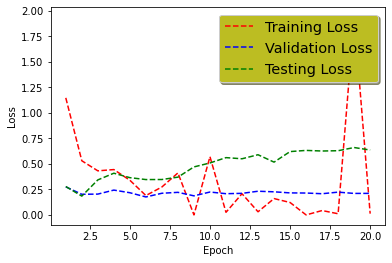

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, args.epochs+1, 1), np.array(train_loss_list), 'r--', label='Training Loss')
ax.plot(np.arange(1, args.epochs+1, 1), np.array(val_loss_list), 'b--', label='Validation Loss')
ax.plot(np.arange(1, args.epochs+1, 1), np.array(test_loss_list), 'g--', label='Testing Loss')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C8')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 5. Accuracy vs Epoch plot

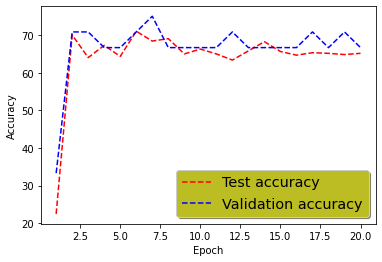

In [27]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, args.epochs+1, 1), np.array(test_accuracy_list), 'r--', label='Test accuracy')
ax.plot(np.arange(1, args.epochs+1, 1), np.array(val_accuracy_list), 'b--', label='Validation accuracy')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C8')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 6. Performance on Validation Set

Average performance: 17/24 = 70.83333333333333%


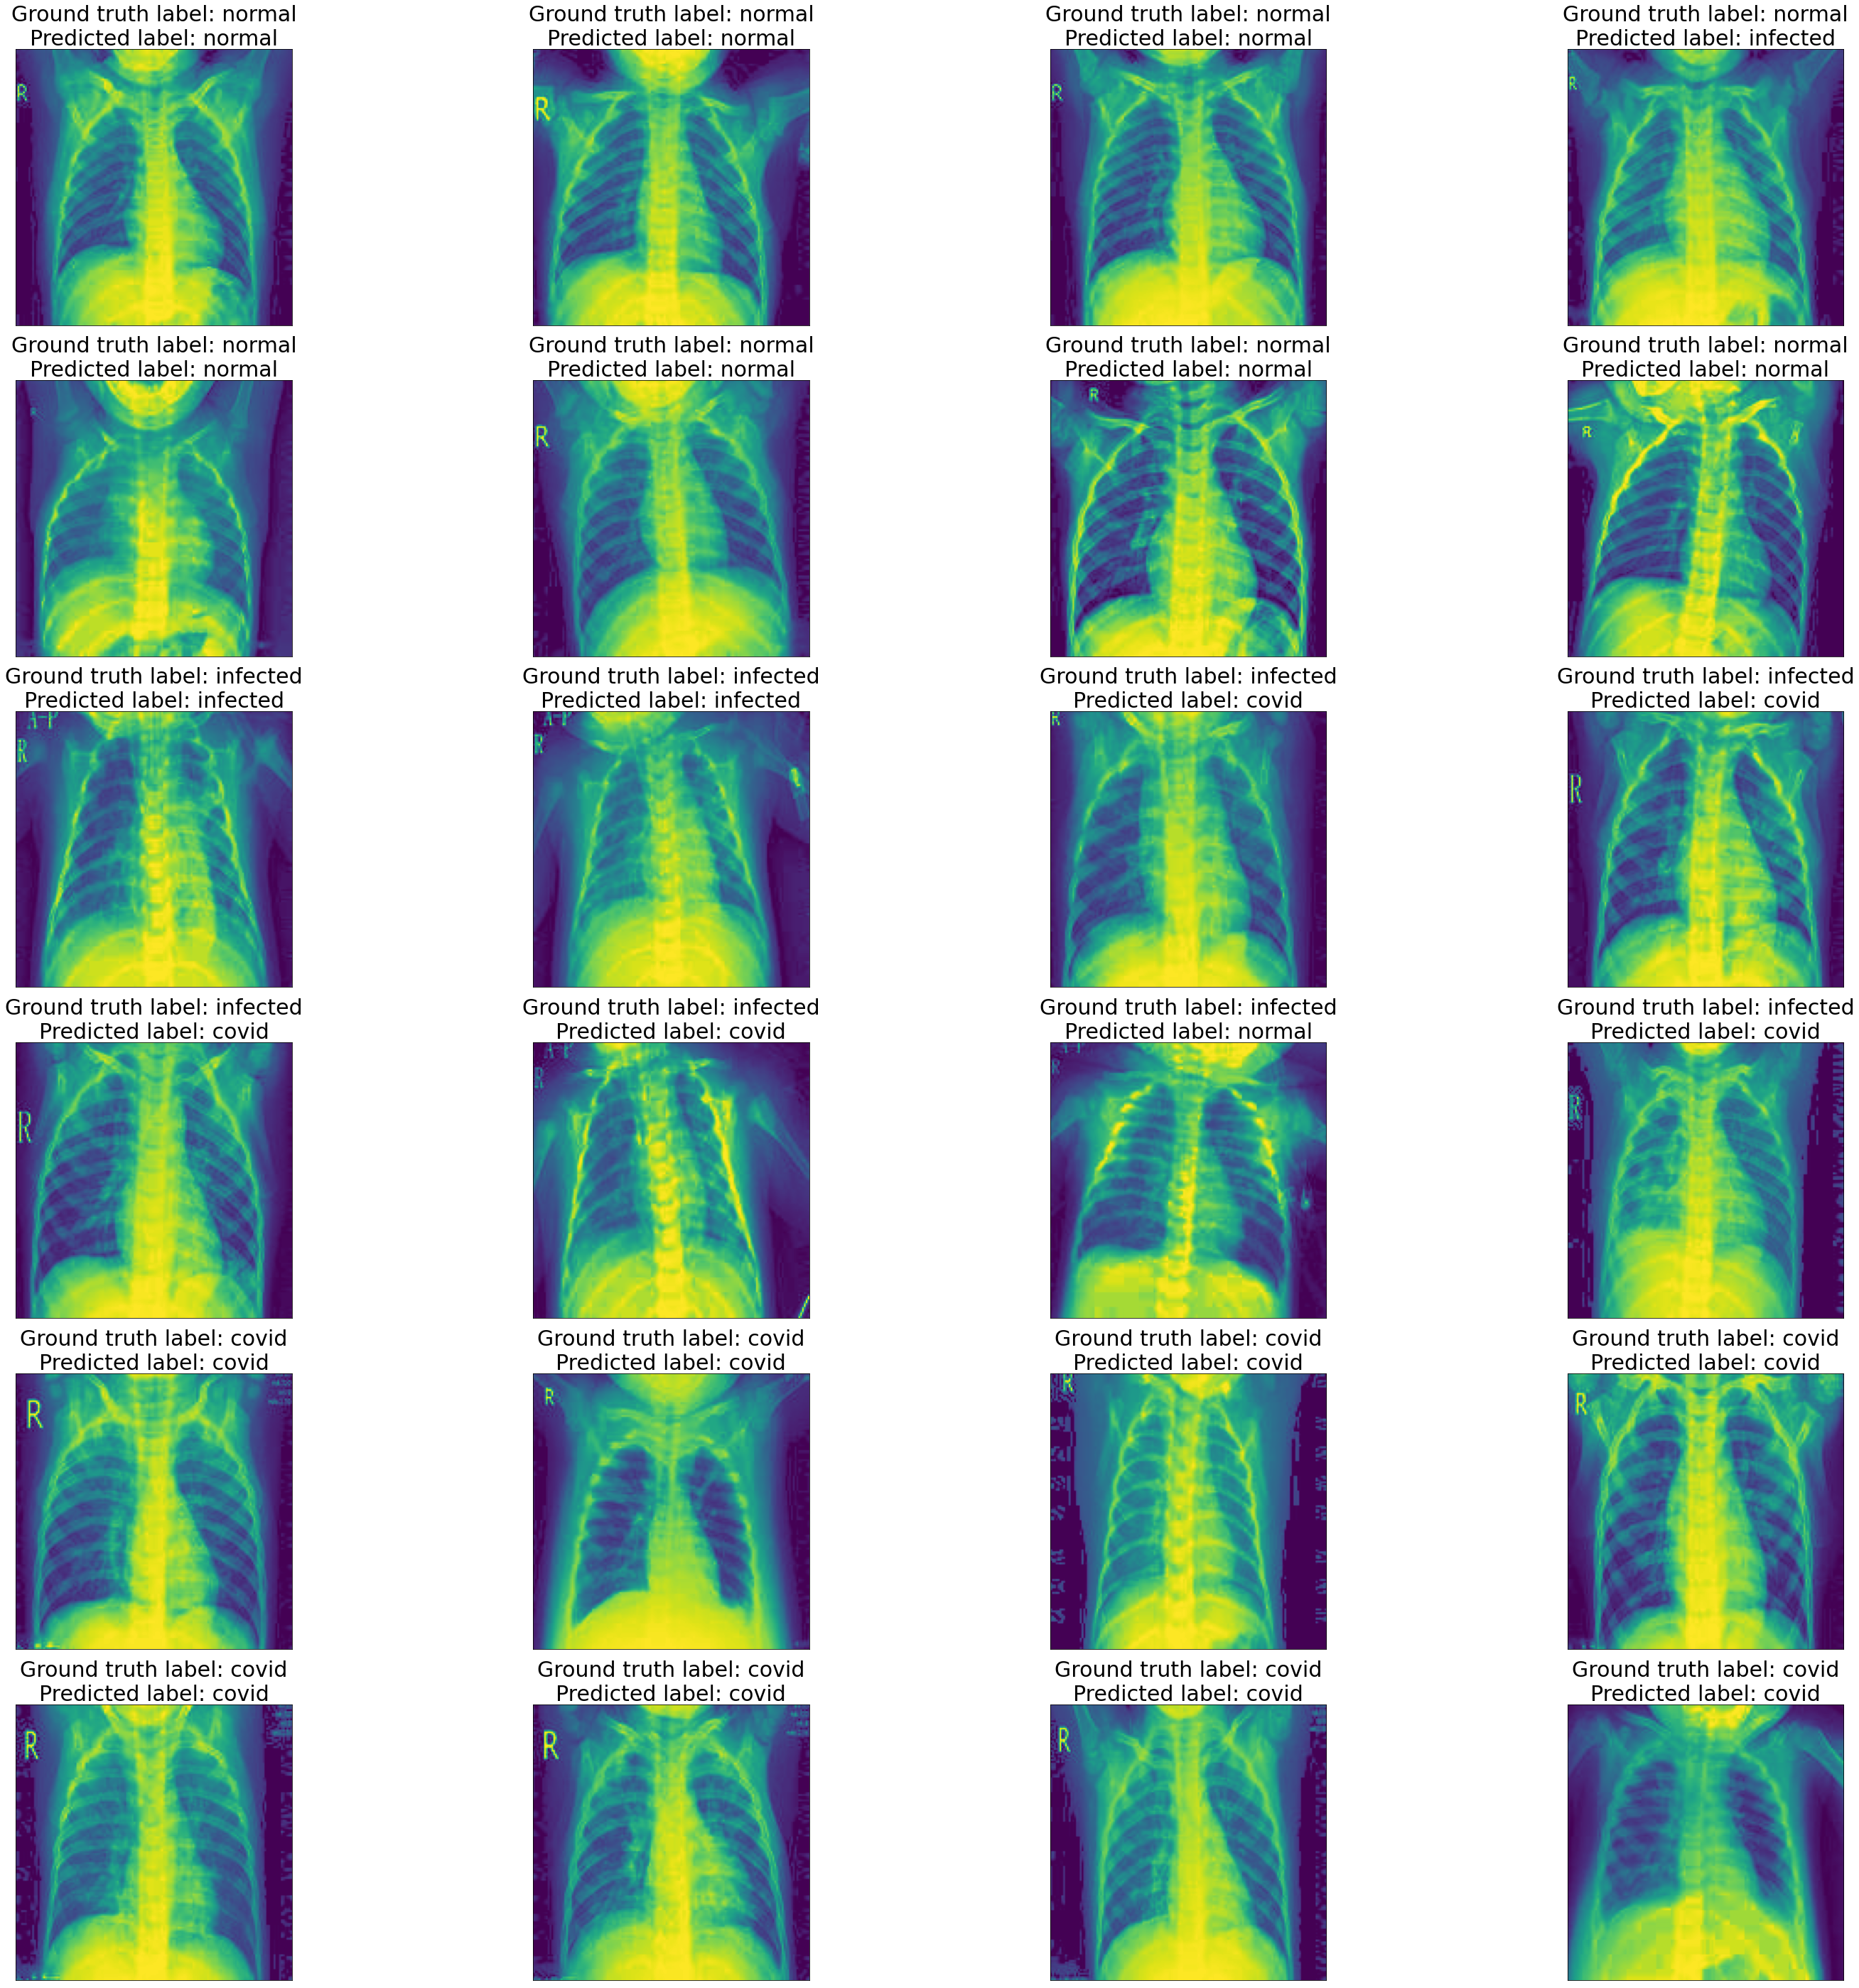

[[8 0 0]
 [5 2 1]
 [0 1 7]]
              precision    recall  f1-score   support

       covid      0.615     1.000     0.762         8
    infected      0.667     0.250     0.364         8
      normal      0.875     0.875     0.875         8

    accuracy                          0.708        24
   macro avg      0.719     0.708     0.667        24
weighted avg      0.719     0.708     0.667        24



In [28]:
model = Net().to(device)
model.load_state_dict(torch.load("./cnn_final.pt"))
classes = {0: 'normal', 1: 'infected', 2: 'covid'}

val_loader = DataLoader(ld_val, batch_size = 1, shuffle = False)
val_pred_list = []
with torch.no_grad():
    for data, target in val_loader: 
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        val_pred_list.append(classes[int(pred)])
    

class_val = ["normal","normal","normal","normal","normal","normal","normal","normal",
             "infected","infected","infected","infected","infected","infected","infected","infected",
             "covid","covid","covid","covid","covid","covid","covid","covid"]
accuracy = 0
for label_index in range(len(val_pred_list)):
    if (val_pred_list[label_index] == class_val[label_index]):
        accuracy += 1
        
print("Average performance: " + str(accuracy) + "/" + str(len(val_pred_list)) + " = " + str(100 * accuracy/len(val_pred_list)) + "%")

f = plt.figure(figsize=(50, 50))
axes = []

for a in range(3 * 8):
    
    classes = class_val[a]

    axes.append(f.add_subplot(6, 4, a+1))
    
    plt.xticks([], [])
    plt.yticks([], [])
    
    subplot_title = ("Ground truth label: " + classes + "\nPredicted label: " + val_pred_list[a])
    axes[-1].set_title(subplot_title, size = 30)
    ld_val.show_img("val", classes, a%8)
    

plt.show()

print(metrics.confusion_matrix(class_val, val_pred_list))
print(metrics.classification_report(class_val, val_pred_list, digits=3))

## 7. Loader Function

In [29]:
def loader_function(model_abs_path):
    '''
    Takes in absolute path of model and checks the accuracy of the model
    '''
    class args:
      batch_size = 16 #'input batch size for training (default: 32)')
      test_batch_size = 1000 #'input batch size for testing (default: 1000)')
      epochs = 20 #'number of epochs to train (default: 14)') # 9~10 is good actually
      lr = 0.8 #'learning rate (default: 1.0)')
      gamma = 0.7 #'Learning rate step gamma (default: 0.7)')
      no_cuda = False #'disables CUDA training')
      dry_run = False #'quickly check a single pass')
      seed = 1 #'random seed (default: 1)')
      log_interval = 1000 #'how many batches to wait before logging training status')
      save_model = True #'For Saving the current Model')

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #model_path = './hist_mirrored_cnn/cnn_epoch8.pt'

    model = Net()
    model.load_state_dict(torch.load(model_abs_path))
    model.to(device)

    bs_val = 4
    # Dataloader from dataset (test and val)
    test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
    val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

    val_loss_list = []
    val_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    test_accuracy, test_loss = test(model, device, test_loader)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    val_accuracy, val_loss = validate(model, device, val_loader)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    
loader_function('./cnn_final.pt')


Test set: Average loss: 0.6450, Accuracy: 400/614 (65%)


Validation set: Average loss: 0.2110, Accuracy: 16/24 (67%)

